In [1]:
from jax import config
config.update("jax_enable_x64", True)

import jax.numpy as np
import numpy as onp
from jax import jacfwd, grad, jit, vmap, hessian
from jaxlie import SE2, SO2, manifold
import meshcat
from meshcat import transformations as tfm
from meshcat import geometry as geom
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

def euler_step(x, f, dt, *args):
    return x + f(x, *args) * dt

def rk4_step(x, f, dt, *args):
    # one step of runge-kutta integration
    k1 = dt * f(x, *args)
    k2 = dt * f(x + k1/2, *args)
    k3 = dt * f(x + k2/2, *args)
    k4 = dt * f(x + k3, *args)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

# 2D Planar Drone Backflip using Direct methods and Direct Shooting MPC

In this homework, we will be controlling a 2D drone to perform a backflip maneuver using direct optimal control in the style of MPC!


## Dynamics Model 
We will be using a 2D (planar) drone system with two force inputs at each robot (see below).

![drone](quadrotor2d.png)


The manipulator equation of the drone are given as 
\begin{align*}
    m \ddot{p_x} &= - (u_1 + u_2) \sin(\theta) \\ 
    m \ddot{p_y} &= (u_1 + u_2) \cos(\theta) - m g \\ 
    I \ddot{\theta} &= r (u_1 - u_2)
\end{align*}
where $m$ is the mass, $I$ is the inertia, $g$ is gravity, $r$ is the distance from the center to the base of the propeller, and the state is given as $x=[p_x, p_y, \theta, \dot{p_x}, \dot{p_y}, \dot{\theta}]$.
The degrees of freedom at the $x,y$ position, drone rotation relative to the world $\theta$, and there are two force inputs $u_1, u_2$ for each rotor. 

As we are using a direct transcription approach, we need to write the dynamics as a discrete-time system, i.e., $x[k+1] = x[k] + dt * f(x[k], u[k])$

In [2]:
_dt = 0.1
_g  = 9.81
_c1 = 0.02
_c2 = 0.02
_r = 0.1
_I = 0.1
_m = 0.1

def f(x, u):
    """
        Input: state x=[px,py, theta, pxdt, pydt, thetadt], control u = [u1, u2]
        output: \dot{x}
    """
    px, py, th, pxt, pyt, tht = x
    u1, u2 = u
    F = u1+u2
    T = u1-u2
    xtt = - F * np.sin(th) / _m
    ytt = F * np.cos(th) / _m - _g
    thtt =  _r * T/_I
    return np.array([pxt, pyt, tht, xtt, ytt, thtt])

@jit
def F(x, u):
    """
        solves x[t+dt] = x[t] + dt * f(x[t], u[t])
    """
    return euler_step(x, f, _dt, u)

# Traj-Opt with Direct Transcription and Constraints

## Q1 10 pts: Discrete-Time Backflip Objective 

Now we need to write down the objective function in discrete time. 
Direct methods require that we compute the whole objective function is discrete time and be able to take derivatives. Let's write the objective function that takes in discrete trajectories for state and control $X = [x_0, x_1, \ldots x_N], U=[u_0, u_1, \ldots, u_{N-1}]$.

For this running cost, we will only focus on penalizing control
$$
    \ell(x, u) = \Vert u \Vert_R^2
$$
and define the backflip using terminal cost of 
$$
    m(x) = \frac{1}{2} (x-x_d)^\top Q_f (x-x_d)
$$
where $x_f = [0,0,2 \pi,0,0,0]$
$$
\begin{equation}
\mathcal{J}(x, u) = \sum_{k=0}^{k=N-1} \ell(x_k,u_k) dt + m(x_N).
\end{equation}
$$
and $Q_f, R$ are weights that penalize certain terms more than others. 
We will use $Q_f=\text{diag}([4,4,1,0.1,0.1,0.1])$, $R=0.01$ and an integration step of $\Delta t = 0.1$. 


In [21]:
_xd = np.array([0., 0., 2*np.pi, 0., 0.0, 0.])
_Qf = np.diag(np.array([4., 4., 1., .01, .01, .01]))

def cost(x, u):
    return _r*np.sum(u**2)
def terminal_cost(x):
    return 1/2 * ((x - _xd).transpose() @ _Qf @ (x - _xd))

def objective_fun(X, U):
    J = 0.0
    for x,u in zip(X[:-1], U):
        J += cost(x, u)
    print(J)
    return  terminal_cost(X[-1])

check you answer below

Objective func J(X, U): 19.757208802178717

In [22]:
N_test = 10
x0_test = np.array([0.1,0.3,0.4,0.2,0.4,0.5])
xf_test = np.zeros(6)
# the index order is N x n
X_test = np.linspace(x0_test,xf_test,num=N_test)
U_test = np.ones((N_test-1, 2))

print(
    'Objective func J(X, U):', objective_fun(X_test, U_test)
)

1.7999999999999998
Objective func J(X, U): 19.739208802178716


## Q2 20 pts: Constraints

Here we will build up the equality and inequality constraints. 
Recall that for the equality constraints we want the dynamics and initial condition to hold, that is 
$$
    \begin{align}
    x_0 - \bar{x}_0 = 0 \\
    x_{k+1} - F(x_k, u_k) = 0
    \end{align}
$$
and we also want the control to be bounded 
$$
    \begin{align}
    u_t \ge 0 \\ 
    u_t \le 2
    \end{align}
$$
as the drone can only generate upward thrust.
To speed up the code use the jax `vmap` function to vectorize your dynamics over each state-control index value.

In [ ]:
def eq_constr(X, U, args):
    """
        h(x) = 0
            Inputs: X, U as nd_arrays of size N x n and N-1 x m
                    args as a dictionary containing a term key x0 for the init cond
            Outputs: N x n state constraint evaluated at X, U
                x[0] - x0,
                x[k+1] - F(x[k], u[k]) forall k in [0,N-1]
    """
    x0 = args['x0']
    return np.vstack([
        # ADD CODE HERE
    ])

def ineq_constr(X, U, args=None):
    """
        Convention is g(x) <= 0
            Inputs: X, U trajectory
    """
    ctrl_ineq_contr = [
        # ADD CODE HERE
    ]
    return np.concatenate(ctrl_ineq_contr)

check your answer below

[[ 0.          0.          0.          0.          0.          0.        ]
 [-0.35       -0.35       -0.35        1.43294197 -0.34960461 -0.25      ]
 [-0.325      -0.325      -0.325       1.11327752 -0.73237774 -0.25      ]
 [-0.3        -0.3        -0.3         0.70885108 -1.02416512 -0.25      ]
 [-0.275      -0.275      -0.275       0.24480792 -1.20682484 -0.25      ]] 
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [ ]:
N_test = 5
x0_test = np.ones(6)
xf_test = np.zeros(6)
# the index order is N x n
X_test = np.linspace(x0_test,xf_test,num=N_test)
U_test = np.ones((N_test-1, 2))
test_args = {
    'x0' : x0_test,
}
print(
    eq_constr(X_test, U_test, test_args), '\n',
    ineq_constr(X_test, U_test, test_args)
)

[[ 0.          0.          0.          0.          0.          0.        ]
 [-0.35       -0.35       -0.35        1.43294197 -0.34960461 -0.25      ]
 [-0.325      -0.325      -0.325       1.11327752 -0.73237774 -0.25      ]
 [-0.3        -0.3        -0.3         0.70885108 -1.02416512 -0.25      ]
 [-0.275      -0.275      -0.275       0.24480792 -1.20682484 -0.25      ]] 
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


## Q3 20 pts: Augmented Lagrangian 

Here we will formulate the augmented Lagrangian for the direct transcription problem. We will use a specific form of the augmented Lagrangian (different from what we saw in class) that has more stable behavior when solving. The augmented Lagrangian you will code up is of the form 
$$
\begin{align}
    \mathcal{L}(X, U, \Lambda, \Gamma) &= \mathcal{J}(X, U) \\ 
    &+ \sum_i \Lambda_i h_i(X, U) + \frac{c}{2} h_i(X, U)^2 \\ 
    &+ \frac{1}{2 c} \sum_j \max(0, \Gamma_j + c g_j(X, U) )^2 - \Gamma_j^2
\end{align}
$$
We can use element-wise math with the `*` operator with python numpy/jax to batch calculate each constraint value and any square terms. Thus, we can code up the augmented Lagrangian as 
$$
\begin{align}
    \mathcal{L}(X, U, \Lambda, \Gamma) &= \mathcal{J}(X, U) \\ 
    &+ \sum \left( \Lambda * h(X, U) + \frac{c}{2} h(X, U)^2 \right) \\ 
    &+ \frac{1}{2 c} \sum \left( \max(0, \Gamma + c g(X, U) )^2 - \Gamma^2\right)
\end{align}
$$

In [ ]:
def AugmentedLagrangian(params, args=None):
    """
        Input: params, a dictionary containing X, U, Lam, Gamma
                    with keys of the same variable name
               arms, a dictionary of constant arguments that may be useful in other
                functions
        Output: scalar augmented Lagrangian evaluations
    """
    X       = params['X']
    U       = params['U']
    Lam     = params['Lam']
    Gamma   = params['Gamma']
    c       = args['c']
    _eq_eval    = eq_constr(X, U, args)
    _ineq_eval  = ineq_constr(X, U, args)

    return # ADD CODE HERE

check your answer below

23.972359417336303 
 {'Gamma': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float64), 'Lam': Array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.35      , -0.35      , -0.35      ,  1.43294197, -0.34960461,
        -0.25      ],
       [-0.325     , -0.325     , -0.325     ,  1.11327752, -0.73237774,
        -0.25      ],
       [-0.3       , -0.3       , -0.3       ,  0.70885108, -1.02416512,
        -0.25      ],
       [-0.275     , -0.275     , -0.275     ,  0.24480792, -1.20682484,
        -0.25      ]], dtype=float64), 'U': Array([[1.42167127, 1.37167127],
       [1.32172575, 1.27172575],
       [1.26563076, 1.21563076],
       [1.25687403, 1.20687403]], dtype=float64), 'X': Array([[ 0.35      ,  0.35      ,  1.31007943, -1.39794197,  0.38460461,
         0.285     ],
       [-0.025     , -0.025     ,  0.60571143,  0.35216445,  0.41527313,
         0.0325    ],
       [-0.025     , -0.025     ,  0.23712886,  0.43442644,  0.32178739,
         0.03      ],
       [-0.025     , -0.025     , -0.14775162,  0.49154316,  0.21015972,
         0.0275    ],
       [-0.275     , -0.275     , -6.55818531,  0.24480792, -1.20682484,
        -0.25      ]], dtype=float64)}


In [ ]:
N_test = 5
x0_test = np.ones(6)
xf_test = np.zeros(6)

# the index order is N x n
X_test = np.linspace(x0_test,xf_test,num=N_test)
U_test = np.ones((N_test-1, 2))
test_params = {
    'X' : X_test,
    'U' : U_test
}
test_args = {
    'x0' : x0_test,
    'c' : 1.0
}
test_params.update(
    {
        'Lam' : np.zeros_like(eq_constr(X_test, U_test, test_args)),
        'Gamma' : np.zeros_like(ineq_constr(X_test, U_test, test_args))
     }
)
print(
    AugmentedLagrangian(test_params, test_args), '\n',
    grad(AugmentedLagrangian)(test_params, test_args)
)

23.972359417336303 
 {'Gamma': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float64), 'Lam': Array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.35      , -0.35      , -0.35      ,  1.43294197, -0.34960461,
        -0.25      ],
       [-0.325     , -0.325     , -0.325     ,  1.11327752, -0.73237774,
        -0.25      ],
       [-0.3       , -0.3       , -0.3       ,  0.70885108, -1.02416512,
        -0.25      ],
       [-0.275     , -0.275     , -0.275     ,  0.24480792, -1.20682484,
        -0.25      ]], dtype=float64), 'U': Array([[1.42167127, 1.37167127],
       [1.32172575, 1.27172575],
       [1.26563076, 1.21563076],
       [1.25687403, 1.20687403]], dtype=float64), 'X': Array([[ 0.35      ,  0.35      ,  1.31007943, -1.39794197,  0.38460461,
         0.285     ],
       [-0.025     , -0.025     ,  0.60571143,  0.35216445,  0.41527313,
         0.0325    ],
       [-0.025     , -0.025 

## Q4 10 pts: A First-Order minimax solver 

Here, we will put together all the missing pieces to create our first solver. Given the augmented Lagrangian above, we want to solve the following problem 
$$
\begin{equation}
    \max_{\Lambda, \Gamma} \min_{X, U} \mathcal{L}(X, U, \Lambda, \Gamma)
\end{equation}
$$
which can be solved with a first-order gradient method where we iterate on the following 
$$
\begin{align}
X \gets X - \alpha \nabla_x \mathcal{L} \\ 
U \gets U - \alpha \nabla_u \mathcal{L} \\ 
\Lambda \gets  \Lambda + \alpha \nabla_\lambda \mathcal{L} \\ 
\Gamma \gets \Gamma + \alpha \nabla_\gamma \mathcal{L} \\ 
\end{align}
$$
and $\alpha$ is a positive step-size.

Fill in the code below using the provided jitted and gradient functions. Note that `jitted_dLdp` returns a dictionary of derivative values with the same keys used in `params` for which you can access. 

In [ ]:
jitted_Lagrangian   = jit(AugmentedLagrangian)
jitted_dLdp         = jit(grad(AugmentedLagrangian))
jitted_obj_fun      = jit(objective_fun)
jitted_Lagrangian(test_params, test_args)
jitted_dLdp(test_params, test_args)

def first_order_minimax(params, args, step_size=1e-1, tol=1e-3, max_iter=10_000):
    for _ in range(max_iter):
        # calculate the derivatives using jitted_dLdp
        # ADD CODE HERE
        # perform updates on each parameter (reuse the params dictionary)
        # ADD CODE HERE
        # check to see if tolerance is satisfied
        # ADD CODE HERE
        if ....
            print('Early tol condition met!')
            break
    # when finished, spit out the loss
    print('loss', jitted_obj_fun(params['X'], params['U']))
    return params

## Q5 10 pts Bring it all together

Solve your first drone back-flip! Setup the initial conditions of the problem below and solve + plot your solution, making sure constraints are satisfied. Contraint multipliers should be the same shape and dimension of the constraint output and be initializes as zeros (use the `np.zeros_like` function). The initial trajectory guess for X should be an interpolating solution from x0 to xf (hint use `np.linspace` with the num argument as N). Controls should be initialized with ones of size N-1 x m where m=2. 

In [ ]:
t0 = 0
tf = 6
N = int(tf/_dt)
x0 = np.zeros(6)
xf = _xd.copy()

# the index order is N x n use np array
X = # ADD CODE HERE
U = # ADD CODE HERE
params = {
    'X' : X,
    'U' : U
}
args = { # x0 should be the initial condition, leave c alone as that is used for the constraints
    'x0' : ,# ADD CODE HERE
    'c' : 1.0
}

# Hint: use the constraints themselves to spit out an array for which you will initialize as zeros
params.update(
    {
        'Lam' : # ADD CODE HERE,
        'Gamma' : # ADD CODE HERE,
     }
)

Solve and Plot your solution. Please label the axis and plot the first three values of the state and all the controls (see example below). 

![image.png](plot_ex.png)
loss should be 
loss 0.15348441979967503

loss 0.15348441979967503


Text(0, 0.5, 'state and control')

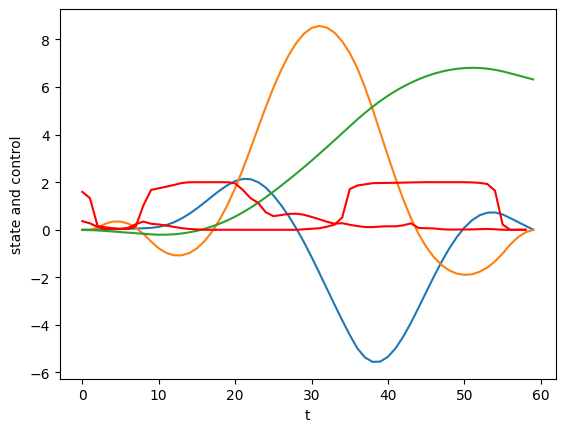

In [ ]:
# ADD CODE HERE

## Visualize the solution 

In [ ]:
viz = meshcat.Visualizer()

drone  = viz["drone"]
drone_body = drone["body"]
drone_body.set_object(
    geom.Box([0.1,0.5,0.02])
)
drone_propFL = drone["propFL"]
drone_propFL.set_transform(tfm.translation_matrix([0.,-0.25,0.05])@tfm.rotation_matrix(np.pi/2,[1,0,0]))
drone_propFL.set_object(
    geom.Cylinder(height=0.01, radius=0.2)
)

drone_propFR = drone["propFR"]
drone_propFR.set_transform(tfm.translation_matrix([0.,0.25,0.05])@tfm.rotation_matrix(np.pi/2,[1,0,0]))
drone_propFR.set_object(
    geom.Cylinder(height=0.01, radius=0.2)
)
viz.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


Animate

In [ ]:
X = params['X']
for t in range(N):
    _x = X[t]
    q, qdot = np.split(_x, 2)
    drone.set_transform(
        tfm.translation_matrix([0,q[0],q[1]]) @ tfm.rotation_matrix(q[2],[1,0,0])
    )
    time.sleep(_dt)

# MPC-based solution of drone backflip

Here, we will solve the same problem but instead running an MPC controller instead of trajectory optimization. We will make several reductions to the problem above to make the MPC run faster. 

## Q6 10pts: Soft control constraints

First we will reduce the problem to a shooting based objective with soft constraints. Let's construct a function that, given an initial state condition and a control sequence returns a state and control trajectory. We will also incorporate a soft control constraint using a differentiable saturation function `umax*(tanh(x)/2 +0.5)` into the forward shooting which returns a smooth approximation of a function clip between 0 and umax=2. We will use this saturated value in the objective function to compute the cost of control.

In [ ]:
def u_sat(u):
    return # ADD CODE HERE

def shoot_F(x0, U):
    x = x0.copy()
    X = [x.copy()]
    U_sat = []
    for u in U:
        # ADD CODE HERE
        # USE THE .append function for the lists X, U_sat to append new state and saturated control
    return np.array(X), np.array(U_sat)

test your code

(10, 6) (9, 2) (Array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  2.54218831,
         0.        ],
       [ 0.        ,  0.25421883,  0.        ,  0.        ,  5.08437662,
         0.        ],
       [ 0.        ,  0.76265649,  0.        ,  0.        ,  7.62656494,
         0.        ],
       [ 0.        ,  1.52531299,  0.        ,  0.        , 10.16875325,
         0.        ],
       [ 0.        ,  2.54218831,  0.        ,  0.        , 12.71094156,
         0.        ],
       [ 0.        ,  3.81328247,  0.        ,  0.        , 15.25312987,
         0.        ],
       [ 0.        ,  5.33859546,  0.        ,  0.        , 17.79531818,
         0.        ],
       [ 0.        ,  7.11812727,  0.        ,  0.        , 20.3375065 ,
         0.        ],
       [ 0.        ,  9.15187792,  0.        ,  0.        , 22.87969481,
         0.        ]], dtype=float64), Array([[1.76159416, 1.76159416],
       [1.76159416, 1.76159416],
       [1.76159416, 1.76159416],
       [1.76159416, 1.76159416],
       [1.76159416, 1.76159416],
       [1.76159416, 1.76159416],
       [1.76159416, 1.76159416],
       [1.76159416, 1.76159416],
       [1.76159416, 1.76159416]], dtype=float64))


In [ ]:
x0 = np.zeros(6)
U = np.ones((9,2))
print(
    shoot_F(x0,U)[0].shape, shoot_F(x0,U)[1].shape,
    shoot_F(x0,U)
)

(10, 6) (9, 2) (Array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  2.54218831,
         0.        ],
       [ 0.        ,  0.25421883,  0.        ,  0.        ,  5.08437662,
         0.        ],
       [ 0.        ,  0.76265649,  0.        ,  0.        ,  7.62656494,
         0.        ],
       [ 0.        ,  1.52531299,  0.        ,  0.        , 10.16875325,
         0.        ],
       [ 0.        ,  2.54218831,  0.        ,  0.        , 12.71094156,
         0.        ],
       [ 0.        ,  3.81328247,  0.        ,  0.        , 15.25312987,
         0.        ],
       [ 0.        ,  5.33859546,  0.        ,  0.        , 17.79531818,
         0.        ],
       [ 0.        ,  7.11812727,  0.        ,  0.        , 20.3375065 ,
         0.        ],
       [ 0.        ,  9.15187792,  0.        ,  0.        , 22.87969481,
         0.        ]], dtype=float64), Array([[1.7615941

## Q7 20 pts: Shooting-Based Objective Function

Here, we will need to redefine the cost function and terminal cost defined previously as MPC plans on smaller time-scales with a receding horizon (terminal time is then always moving away from the controller). As a result, we need to inform the controller on what the task is throughout planning (especially since MPC methods are simpler and need a lot more help to inform of solutions). We will define a quadratic cost with a terminal condition 
$$
    J = \frac{1}{N} \sum (x_k - x_d)^\top Q (x_k - x_d) + u_k^\top R u_k + (x_N - x_d)^\top Q_f (x_N - x_d)
$$
where $Q, Q_f, R$ are define below, and $N$ is the discrete time horizon (used to normalize the objective value).

In addition, this function will take in a control sequence an initial state and implicitly simulate the state trajectory using the shooting function and return a scalar loss value for the state/control trajectories.

In [ ]:
_Q = np.diag(np.array([2., 2., 80., .01, .01, .001]))
_Qf = np.diag(np.array([4., 4., 80., .01, .01, .01]))
_R = np.diag(np.array([0.0001, 0.0001]))
def soft_objective(x0, U):
    X, U_sat = shoot_F(x0, U)
    J = 0.0
    for x,u in zip(X[:-1], U_sat):
        # ADD CODE HERE
    return

check your solution

3214.2475970870037 
 [[-1.06703508e+01  1.97283558e+01]
 [-7.96106806e+00  1.56823704e+01]
 [-5.67185427e+00  1.20607246e+01]
 [-3.79416819e+00  8.87195955e+00]
 [-2.31519799e+00  6.12888718e+00]
 [-1.21786119e+00  3.84858990e+00]
 [-4.80804735e-01  2.05242081e+00]
 [-7.84049178e-02  7.66003598e-01]
 [ 1.92325660e-02  1.92325660e-02]]


In [ ]:
x0 = np.zeros(6)
U = np.ones((9,2))
print(
    soft_objective(x0, U), '\n',
    grad(soft_objective, argnums=1)(x0,U)
)

3214.2475970870037 
 [[-1.06703508e+01  1.97283558e+01]
 [-7.96106806e+00  1.56823704e+01]
 [-5.67185427e+00  1.20607246e+01]
 [-3.79416819e+00  8.87195955e+00]
 [-2.31519799e+00  6.12888718e+00]
 [-1.21786119e+00  3.84858990e+00]
 [-4.80804735e-01  2.05242081e+00]
 [-7.84049178e-02  7.66003598e-01]
 [ 1.92325660e-02  1.92325660e-02]]


## Q8 20 pts: MPC formulation 

Here, we will form the MPC controller. Recall that the control input needs to be time shifted. This will be done using an inplace assignment based on the jax syntax `U = U.at[:-1].set(U[1:])`, fill in the algorithm to update the control using the step_size variable as a first-order method as done above. 

In [ ]:
jitted_grad_soft_obj = jit(grad(soft_objective, argnums=1))
# evaluate this one to compile
jitted_grad_soft_obj(x0,U)

def mpc(x0, U, step_size=1e-3):
    # shift the controls
    # ADD CODE HERE
    for i in range(4_000):
        # ADD CODE HERE

        # check if |dU| is small
        if np.linalg.norm(dU) < 1e-3:
            break
    return U

check your solution
[[ 3.42343083 -3.5459795 ]
 [ 3.28741085 -3.42092557]
 [ 3.13115721 -3.27728003]
 [ 2.94804728 -3.10820828]
 [ 2.7276021  -2.90206923]
 [ 2.45177566 -2.63638718]
 [ 2.08636243 -2.25699453]
 [ 1.56687352 -1.5455861 ]
 [ 0.96022509  0.96125492]]


In [ ]:
x0 = np.zeros(6)
U = np.ones((9,2))
print(
    mpc(x0, U)
)

[[ 3.42343083 -3.5459795 ]
 [ 3.28741085 -3.42092557]
 [ 3.13115721 -3.27728003]
 [ 2.94804728 -3.10820828]
 [ 2.7276021  -2.90206923]
 [ 2.45177566 -2.63638718]
 [ 2.08636243 -2.25699453]
 [ 1.56687352 -1.5455861 ]
 [ 0.96022509  0.96125492]]


## Q9 10 pts: Animate and run the algorithm in real-time. 

Run the MPC in the loop using the dynamics F(x, u) as a stepping function with MPC generating controls. Recall that you only apply the first control U[0] to the dynamics. Render what the drone is doing as you step forward the sim. 

In [ ]:
viz = meshcat.Visualizer()

drone  = viz["drone"]
drone_body = drone["body"]
drone_body.set_object(
    geom.Box([0.1,0.5,0.02])
)
drone_propFL = drone["propFL"]
drone_propFL.set_transform(tfm.translation_matrix([0.,-0.25,0.05])@tfm.rotation_matrix(np.pi/2,[1,0,0]))
drone_propFL.set_object(
    geom.Cylinder(height=0.01, radius=0.2)
)

drone_propFR = drone["propFR"]
drone_propFR.set_transform(tfm.translation_matrix([0.,0.25,0.05])@tfm.rotation_matrix(np.pi/2,[1,0,0]))
drone_propFR.set_object(
    geom.Cylinder(height=0.01, radius=0.2)
)
viz.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


Write Code Here

In [ ]:
tH = 2
N = int(tH/_dt)
x0 = np.zeros(6)
U = np.zeros((N-1, 2))

for t in range(100):
    # ADD CODE HERE
    q, qdot = np.split(x0, 2)
    drone.set_transform(
        tfm.translation_matrix([0,q[0],q[1]]) @ tfm.rotation_matrix(q[2],[1,0,0])
    )
    time.sleep(_dt)


## Extra Credit on any assignment: MPC for Cartpole swingup + balance
write an mpc stabilizing controller for the cart pendulum pendulum is in the upright position following the open-loop control `U[t]`. Visualize the results below.